In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import random

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn import metrics

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from dask.distributed import Client,get_client,LocalCluster
from dask import dataframe as dd

%matplotlib inline
# plt.ion()
# plt.style.use(['dark_background'])

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


try:
    client = get_client()
except:
    client = Client(LocalCluster())

C:\Users\andre\Anaconda3\lib\site-packages\distributed\dashboard\core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [3]:
client

Client Scheduler: tcp://127.0.0.1:52348 Dashboard: http://127.0.0.1:52351/status,Cluster Workers: 4 Cores: 8 Memory: 8.32 GB


In [7]:
import pandas as pd
import numpy as np

In [5]:
df_transaction = dd.read_csv('/Users/andre/DSi9plus/Capstone-Submission/MAD/transaction.csv')
df_test = dd.read_csv('/Users/andre/DSi9plus/Capstone-Mark/test_transaction.csv')

In [9]:
df.mean().compute()

TransactionID     3.282270e+06
isFraud           3.499001e-02
TransactionDT     7.372311e+06
TransactionAmt    1.350272e+02
card1             9.898735e+03
                      ...     
V335              5.916455e+01
V336              2.853090e+01
V337              5.535242e+01
V338              1.511605e+02
V339              1.007009e+02
Length: 380, dtype: float64

In [6]:
#Create a new data frame with columns that starts with V.
df_vtran = df_transaction[[x for x in df_transaction.columns if x[0] == 'V']]

#Create a new data frame with columns that starts with V.
df_vtest = df_test[[x for x in df_test.columns if x[0] == 'V']]

In [7]:
df_vtran = df_vtran.fillna(value=0)
df_vtest = df_vtest.fillna(value=0)

In [11]:
# df_vtran = df_vtran.join(df_transaction['isFraud'])

In [8]:
X, y = df_vtran, df_transaction.isFraud

In [10]:
smote_enn = SMOTEENN(random_state=0)

# Fit the model to generate the data.
oversampled_trainX, oversampled_trainY = smote_enn.fit_resample(X, y)
# oversampled_trainX, oversampled_trainY = sm.fit_sample(df_job_new.drop('salary'), df_job_new['salary'])
oversampled_train = pd.concat([pd.DataFrame(oversampled_trainY), pd.DataFrame(oversampled_trainX)], axis=1)
# oversampled_train.columns = ['salary', 'job_title', 'company_name', 'location', 'position', 'description']

In [11]:
# df = dd.from_pandas( reduce_mem_usage(df_vtran.compute()),npartitions=22)
%whos

Variable                 Type         Data/Info
-----------------------------------------------
Client                   type         <class 'distributed.client.Client'>
DecisionTreeClassifier   ABCMeta      <class 'sklearn.tree._cla<...>.DecisionTreeClassifier'>
LinearSVC                type         <class 'sklearn.svm._classes.LinearSVC'>
LocalCluster             type         <class 'distributed.deploy.local.LocalCluster'>
LogisticRegression       type         <class 'sklearn.linear_mo<...>stic.LogisticRegression'>
PCA                      ABCMeta      <class 'sklearn.decomposition._pca.PCA'>
RandomForestClassifier   ABCMeta      <class 'sklearn.ensemble.<...>.RandomForestClassifier'>
RandomizedSearchCV       ABCMeta      <class 'sklearn.model_sel<...>arch.RandomizedSearchCV'>
SMOTE                    ABCMeta      <class 'imblearn.over_sampling._smote.SMOTE'>
SMOTEENN                 ABCMeta      <class 'imblearn.combine._smote_enn.SMOTEENN'>
SVC                      ABCMeta      <cl

In [12]:
X = oversampled_train.drop(columns='isFraud', axis=1)
y = oversampled_train.isFraud

In [15]:
rfc = RandomForestClassifier()
rfc.fit(X, y)
rfc_y_pred_class = rfc.predict(df_vtest)

MemoryError: 

In [16]:
dfs_vtest

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
npartitions=10,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,f

In [12]:
X = df

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import random

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn import metrics

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline

%matplotlib inline
# plt.ion()
# plt.style.use(['dark_background'])

In [2]:
n = 590540 #number of records in file
s = 10000 #desired sample size
win_data_source = '/Users/andre/DSi9plus/Capstone-Mark/train_transaction.csv'
skip = sorted(random.sample(range(n),n-s))
df_transaction = pd.read_csv(win_data_source, skiprows=skip)

In [3]:
df_cols = pd.read_csv(win_data_source, nrows=1)
df_transaction.columns = df_cols.columns

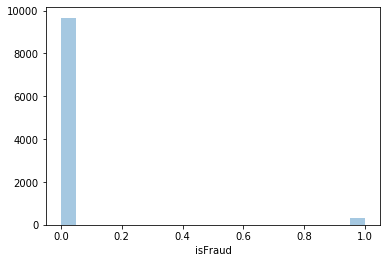

In [4]:
sns.distplot(df_transaction.isFraud,kde=False, bins=20)

In [2]:
win_data_source = '/Users/andre/DSi9plus/Capstone-Mark/train_transaction.csv'
df_transaction = pd.read_csv(win_data_source, nrows=1)

In [3]:
df_transaction.co

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:

import joblib
# client = Client(processes=False)             # create local cluster
# client = Client("scheduler-address:8786")  # or connect to remote cluster

with joblib.parallel_backend('dask'):
    # Your scikit-learn code
    
    tsne = TSNE()
    Y = tsne.fit_transform(X)
    nans = np.sum(np.isnan(Y))

In [16]:
Y

array([[  0.4166944 , -10.885312  ],
       [-13.26665   ,  27.607521  ],
       [-51.368576  ,   0.19880855],
       ...,
       [ 20.556692  ,  -3.3849692 ],
       [-27.169483  ,  18.929195  ],
       [  0.05282674, -16.72518   ]], dtype=float32)

In [ ]:
trust = trustworthiness(X, Y)
print("Trust = ", trust)
assert trust > 0.76
assert nans == 0
del Y

In [ ]:
win_data_source = '/Users/andre/DSi9plus/Capstone-Mark/train_transaction.csv'
skip = sorted(random.sample(range(n),n-s))
df_transaction = pd.read_csv(win_data_source, skiprows=skip)

In [ ]:
@pytest.mark.parametrize('name', dataset_names)

In [ ]:
def test_tsne(name):
    """
    This tests how TSNE handles a lot of input data across time.
    (1) Numpy arrays are passed in
    (2) Params are changed in the TSNE class
    (3) The class gets re-used across time
    (4) Trustworthiness is checked
    (5) Tests NAN in TSNE output for learning rate explosions
    (6) Tests verbosity
    """
    datasets
    X = eval("datasets.load_{}".format(name))().data
    for i in range(3):
        print("iteration = ", i)
        tsne = TSNE(2, random_state=i, verbose=0, learning_rate=2+i)
        # Reuse
        Y = tsne.fit_transform(X)
        nans = np.sum(np.isnan(Y))
        trust = trustworthiness(X, Y)
        print("Trust = ", trust)
        assert trust > 0.76
        assert nans == 0
        del Y
        # Again
        tsne = TSNE(2, random_state=i+2, verbose=1, learning_rate=2+i+2)
        # Reuse
        Y = tsne.fit_transform(X)
        nans = np.sum(np.isnan(Y))
        trust = trustworthiness(X, Y)
        print("Trust = ", trust)
        assert trust > 0.76
        assert nans == 0
        del Y

In [ ]:
@pytest.mark.parametrize('name', dataset_names)

In [ ]:
def test_tsne_default(name):
    datasets
    X = eval("datasets.load_{}".format(name))().data
    for i in range(3):
        print("iteration = ", i)
        tsne = TSNE()
        Y = tsne.fit_transform(X)
        nans = np.sum(np.isnan(Y))
        trust = trustworthiness(X, Y)
        print("Trust = ", trust)
        assert trust > 0.76
        assert nans == 0
        del Y